In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier
#from graphviz import Source   # Install it using: conda install -c conda-forge python-graphviz
from IPython.display import display, SVG

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
# Įsikeliame duomenis
liver_patient = pd.read_csv("duomenys/Indian_Liver_Patient.csv")
liver_patient.head()

#Pervadiname stulpelį dataset į liver_disease
liver_patient.rename(columns={'Dataset': 'Liver_Disease'}, inplace=True)
# Persikoduojame stulpelį lytis (Female=0 and Male = 1).
liver_patient['Gender'] = liver_patient['Gender'].apply(lambda x: 1 if x =='Male' else 0)

# Užpildome praleistas reikšmes vidurkiu 
liver_patient['Albumin_and_Globulin_Ratio'].mean()
liver_patient=liver_patient.fillna(0.94)


In [4]:
liver_patient.shape # Duomenų lentelėje yra 583 stebėjimai ir 11 kintamųjų.

# Pasižiūrime, kiek kiekvienoje grupėje yra stebėjimų.
liver_patient.groupby('Liver_Disease').size()

# Gauname, kad sergančių yra 416, o nesergančių 167 asmenys( 0 - not diseased 1- diseased).

Liver_Disease
1    416
2    167
dtype: int64

# RANDOM FOREST

In [4]:
# The first way
# Train/test mask
#np.random.seed(42)

#mask = np.random.random(liver_patient.shape[0]) < 0.7

#liver_patient.head()

In [5]:
#from sklearn.ensemble import RandomForestClassifier

In [6]:
# rf= RandomForestClassifier(n_estimators = 100)

In [7]:
#rf.fit(liver_patient[mask].drop('Liver_Disease', axis=1), liver_patient[mask]['Liver_Disease'])

In [8]:
#pred = rf.predict(liver_patient[~mask].drop('Liver_Disease', axis=1))

In [9]:
#acc = np.mean(pred == liver_patient[~mask]['Liver_Disease'])
#print(f'Accuracy {acc:.02%}')

# Pirmas modelis

In [16]:

# prepare train and test set
#Apibrėžiame X ir y.
X = liver_patient[['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
        'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
        'Albumin', 'Albumin_and_Globulin_Ratio','Gender']]
y = liver_patient[['Liver_Disease']]


#Duomenų rinkinį padaliname į 75% mokymo duomenų ir 25% bandymo duomenų.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(408, 10) (408, 1) (175, 10) (175, 1)


C:\Users\Vitalija\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Score:  100.0
Random Forest Test Score:  73.71
Accuracy:  0.7371428571428571

Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.91      0.83       125
           2       0.58      0.30      0.39        50

    accuracy                           0.74       175
   macro avg       0.67      0.61      0.61       175
weighted avg       0.71      0.74      0.71       175

Confusion Matrix:
      0   1
0  114  11
1   35  15


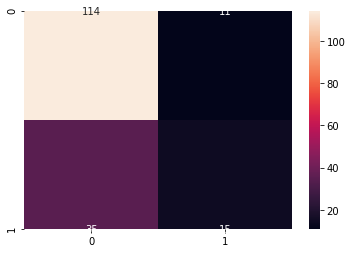

In [17]:
#np.random.seed(150)
rf = RandomForestClassifier(n_estimators=100, random_state=150)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

random_forest_score      = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)


print('Random Forest Score: ', random_forest_score)
print('Random Forest Test Score: ', random_forest_score_test)
#Apskaičiuojame savo modelio tikslumą.
print('Accuracy: ', accuracy_score(y_test,rf_predicted))
print('\nClassification report: \n', classification_report(y_test,rf_predicted))
#Suskaičiuojame Confusion matricą.
cm=pd.DataFrame(confusion_matrix(y_test,rf_predicted))
print("Confusion Matrix:\n", cm)


g = sns.heatmap(confusion_matrix(y_test,rf_predicted), annot=True, fmt="d")

# Feature importance

In [18]:
# Atspausdiname kintamųjų reiškmingumo lentelę.
pd.DataFrame(rf.feature_importances_,
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
# Iš gautos lentelės matome, kad reikšmingiausias kintamasis yra Direct_Bilirubin, 
# o mažiausiai reikšmingas yra Albumin_and_Globulin_Ratio

,0
Age,0.137464
Gender,0.090845
Total_Bilirubin,0.076405
Direct_Bilirubin,0.155201
Alkaline_Phosphotase,0.125745
Alamine_Aminotransferase,0.139214
Aspartate_Aminotransferase,0.093534
Total_Protiens,0.088306
Albumin,0.073186
Albumin_and_Globulin_Ratio,0.020099


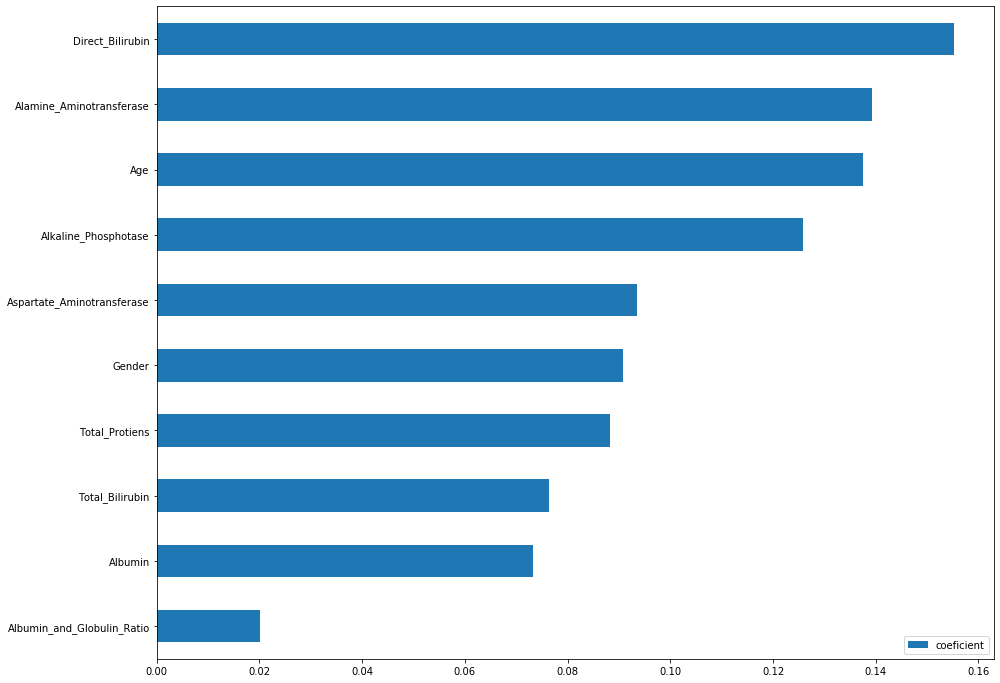

In [19]:
# Taip pat, nubraižome grafiką, kuris vizualiai atskleidžia, kurie kintamieji turi didžiausią
#reikšmingumą,ir kurie mažiausią.
variable_importance=pd.DataFrame(rf.feature_importances_,columns=['coeficient'],
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

# Antras modelis (Pridėjus naujus stulpelius)

In [21]:
#Apsiskaičiuojame Globuliną
liver_patient['Globulin'] = liver_patient['Albumin'] / liver_patient['Albumin_and_Globulin_Ratio']

#Susiskaičiuojam netiesioginį bilirubiną (nekonjuguotas) (jis lygus iš bendro atėmus tiesioginį)
liver_patient['Indirect_Bilirubin'] = liver_patient['Total_Bilirubin'] - liver_patient['Direct_Bilirubin']
liver_patient['Protiens_Ratio'] = liver_patient['Total_Protiens'] / liver_patient['Albumin']

liver_patient.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Disease,Globulin,Indirect_Bilirubin,Protiens_Ratio
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,3.666667,0.6,2.060606
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,4.324324,5.4,2.343750
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3.707865,3.2,2.121212
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,3.400000,0.6,2.000000
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,6.000000,1.9,3.041667


In [22]:

# prepare train and test set


X = liver_patient[['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
        'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
        'Albumin', 'Albumin_and_Globulin_Ratio','Gender','Globulin','Indirect_Bilirubin','Protiens_Ratio']]
y = liver_patient[['Liver_Disease']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(408, 13) (408, 1) (175, 13) (175, 1)


C:\Users\Vitalija\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Score:  100.0
Random Forest Test Score:  72.57
Accuracy:  0.7257142857142858

Classification report: 
               precision    recall  f1-score   support

           1       0.77      0.87      0.82       125
           2       0.53      0.36      0.43        50

    accuracy                           0.73       175
   macro avg       0.65      0.62      0.62       175
weighted avg       0.70      0.73      0.71       175

Confusion Matrix:
      0   1
0  109  16
1   32  18


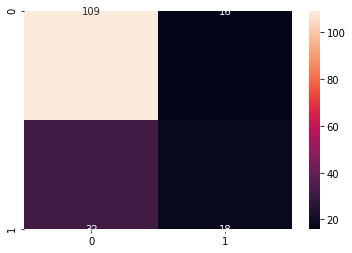

In [23]:
#np.random.seed(150)
rf = RandomForestClassifier(n_estimators=100, random_state=150)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

random_forest_score      = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)


print('Random Forest Score: ', random_forest_score)
print('Random Forest Test Score: ', random_forest_score_test)
print('Accuracy: ', accuracy_score(y_test,rf_predicted))
print('\nClassification report: \n', classification_report(y_test,rf_predicted))
cm=pd.DataFrame(confusion_matrix(y_test,rf_predicted))
print("Confusion Matrix:\n", cm)


g = sns.heatmap(confusion_matrix(y_test,rf_predicted), annot=True, fmt="d")

In [24]:
pd.DataFrame(rf.feature_importances_,
             index=liver_patient.drop('Liver_Disease', axis=1).columns)

,0
Age,0.092326
Gender,0.086348
Total_Bilirubin,0.060641
Direct_Bilirubin,0.114672
Alkaline_Phosphotase,0.097698
Alamine_Aminotransferase,0.107010
Aspartate_Aminotransferase,0.066478
Total_Protiens,0.067318
Albumin,0.057292
Albumin_and_Globulin_Ratio,0.013215


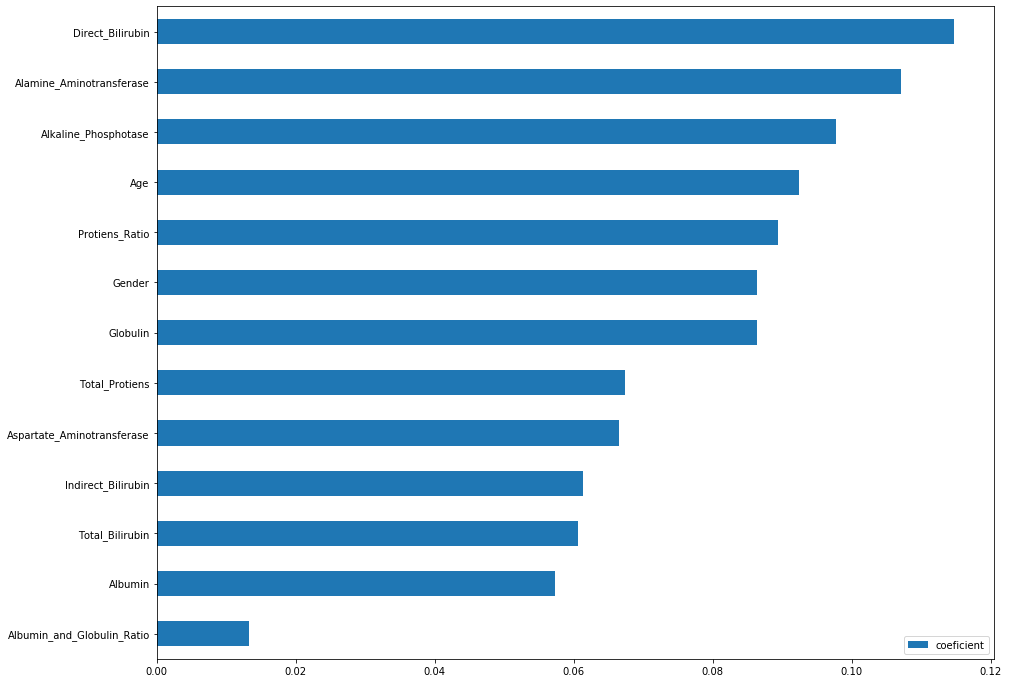

In [25]:
variable_importance=pd.DataFrame(rf.feature_importances_,columns=['coeficient'],
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

# Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier
# Create decision tree object
classifier = DecisionTreeClassifier()

# Train the model using the training sets and check score
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Decision tree Score:  100.0
Decision tree Test Score:  68.57
Accuracy:  0.6228571428571429
Confusion matrix
 [[94 31]
 [35 15]] 

Confusion matrix plot


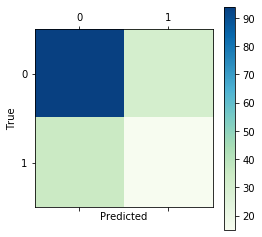

Classfication report:               precision    recall  f1-score   support

           1       0.73      0.75      0.74       125
           2       0.33      0.30      0.31        50

    accuracy                           0.62       175
   macro avg       0.53      0.53      0.53       175
weighted avg       0.61      0.62      0.62       175



In [15]:
# Predict Output

y_pred=classifier.predict(X_test)

dt_score = round(classifier.score(X_train, y_train) * 100, 2)
dt_test = round(classifier.score(X_test, y_test) * 100, 2)

decision_tree_score      = round(rf.score(X_train, y_train) * 100, 2)
decision_tree_score_test = round(rf.score(X_test, y_test) * 100, 2)

print('Decision tree Score: ', decision_tree_score)
print('Decision tree Test Score: ', decision_tree_score_test)
print('Accuracy: ', accuracy_score(y_test,y_pred))

c_m = confusion_matrix(y_test, y_pred)
print ("Confusion matrix\n", c_m,'\n')
ax=plt.matshow(c_m,cmap=plt.cm.GnBu)
print('Confusion matrix plot')
plt.colorbar(ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print('Classfication report:',classification_report(y_test, y_pred)) 
